Mount the Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Data Pre-processing

In [7]:
# Import Necessary Libraries
import os

# Set Directory path for Dataset
os.chdir('/content/gdrive/My Drive')
Dataset = 'Dataset'
Data_Dir = os.listdir(Dataset)
print(Data_Dir)

['with_mask', 'without_mask']


In [8]:
# Import Necessary Libraries
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

img_rows, img_cols = 112, 112

images = []
labels = []

for category in Data_Dir:
  folder_path = os.path.join(Dataset, category)
  for img in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img)
    img = cv2.imread(img_path)

    try:
      # Converting the image into grayscale
      grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      # Resizing the grayscaled image into size 56x56 in order to keep size of the images consistent
      resized_img = cv2.resize(grayscale_img, (img_rows, img_cols))
      images.append(resized_img)
      labels.append(category)

    # Exception Handling in case any error occurs
    except Exception as e:
      print('Exception:',e)

images = np.array(images)/255.0
images = np.reshape(images, (images.shape[0], img_rows, img_cols, 1))

# Perform OneHotEncoding on the labels since the label are in textual form
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels = np.array(labels)

(train_X, test_X, train_y, test_y) = train_test_split(images, labels, test_size=0.25, random_state=0)


Build Convolutional Neural Network Classification Model

In [9]:
# Import Necessary Keras Libraries
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D

# Define model parameters
num_classes = 2
batch_size = 32

# Build CNN model using Sequential API
model = Sequential()

# First layer group containing Convolution, Relu and MaxPooling layers
model.add(Conv2D(64,(3,3), input_shape=(img_rows, img_cols, 1) ))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second layer group containing Convolution, Relu and MaxPooling layers
model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten and dropout layer to stack the output convolutions above as well as cater overfitting
model.add(Flatten())
model.add(Dropout(0.5))

# Softmax Classifier
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

Plot the Model

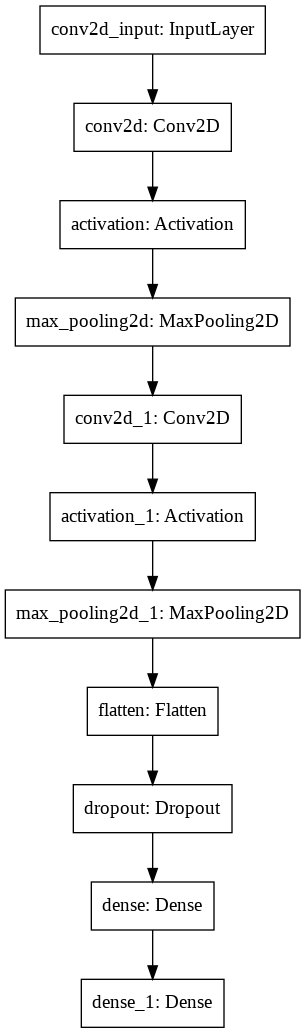

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_architecture.png')

Train the Model

In [11]:
from keras.optimizers import Adam

epochs = 1000

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'] )
fitted_model = model.fit(train_X, train_y, epochs=epochs, validation_split=0.25)

Epoch 1/1000
25/25 [==============================] - 32s 73ms/step - loss: 1.0272 - accuracy: 0.4871 - val_loss: 0.6922 - val_accuracy: 0.4651
Epoch 2/1000
25/25 [==============================] - 1s 55ms/step - loss: 0.6756 - accuracy: 0.6055 - val_loss: 0.8033 - val_accuracy: 0.4651
Epoch 3/1000
25/25 [==============================] - 1s 55ms/step - loss: 0.6710 - accuracy: 0.6292 - val_loss: 0.5007 - val_accuracy: 0.7713
Epoch 4/1000
25/25 [==============================] - 1s 54ms/step - loss: 0.4891 - accuracy: 0.7654 - val_loss: 0.3783 - val_accuracy: 0.8256
Epoch 5/1000
25/25 [==============================] - 1s 55ms/step - loss: 0.2953 - accuracy: 0.8841 - val_loss: 0.2780 - val_accuracy: 0.9070
Epoch 6/1000
25/25 [==============================] - 1s 55ms/step - loss: 0.2430 - accuracy: 0.8939 - val_loss: 0.2439 - val_accuracy: 0.9031
Epoch 7/1000
25/25 [==============================] - 1s 55ms/step - loss: 0.1692 - accuracy: 0.9419 - val_loss: 0.3906 - val_accuracy: 0.817

Plot the Training Loss and Accuracy

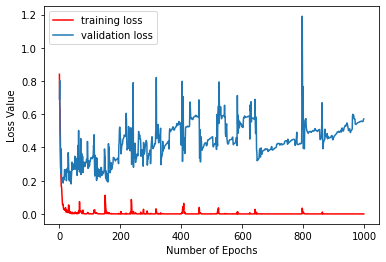

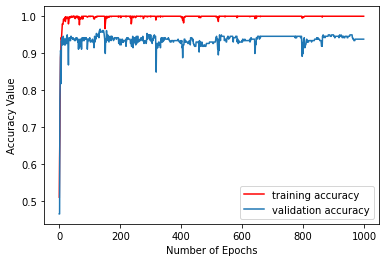

In [12]:
from  matplotlib import pyplot as plt

# Plot Training and Validation Loss
plt.plot(fitted_model.history['loss'], 'r', label='training loss')
plt.plot(fitted_model.history['val_loss'], label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.plot(fitted_model.history['accuracy'], 'r', label='training accuracy')
plt.plot(fitted_model.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

Save the Model

In [14]:
model.save('employee_face_mask_detection_alert_system.h5')